In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [29]:
import random
import matplotlib.pyplot as plt
import os
from glob import glob
from sklearn.preprocessing import StandardScaler , LabelEncoder
from tqdm import tqdm

In [30]:
DATA_DIR = "/kaggle/input/spai-signal-sleep-staging-classification/train/train"

csv_files = glob(os.path.join(DATA_DIR, "*.csv"))
print(f"found :  {len(csv_files)} files")

found :  83 files


In [31]:
def preprocess_time_series_with_fft(files, is_training=True, window_size=480):
    feature_segments = []
    label_segments = [] if is_training else None

    stage_mapping = {"W": 0, "R": 1, "N1": 2, "N2": 3, "N3": 4} 

    for file in tqdm(files, desc="Processing Files"): 
        df = pd.read_csv(file)

        if is_training and 'Sleep_Stage' in df.columns:
            label_data = df['Sleep_Stage'].map(stage_mapping).values
            df = df.drop(columns=['Sleep_Stage']) 

        num_windows = len(df) // window_size
        
        def apply_fft(data):
            fft_data = np.fft.fft(data, axis=0)
            return np.abs(fft_data)

        segment_data = df.values[:num_windows * window_size].reshape(num_windows, window_size, -1)
        fft_segments = np.apply_along_axis(apply_fft, axis=1, arr=segment_data)
        feature_segments.append(fft_segments)

        if is_training:
            window_labels = label_data[:num_windows * window_size].reshape(num_windows, window_size)
            window_labels = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=window_labels)
            label_segments.append(window_labels)

    X_output = np.vstack(feature_segments)  
    y_output = np.hstack(label_segments) if is_training else None 

    return (X_output, y_output) if is_training else X_output


In [32]:
# Load train data (480-row segments)
X_train, y_train_notencoded = preprocess_time_series_with_fft(csv_files, is_training=True, window_size=480)

# Normalize each feature
scaler = StandardScaler()
label_encoder = LabelEncoder()

X_train_shape = X_train.shape
# Reshape to 2D for scaling (batch * timesteps, features)
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train_shape)
y_train = label_encoder.fit_transform(y_train_notencoded)

print("Data processing complete!")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

Processing Files: 100%|██████████| 83/83 [00:56<00:00,  1.46it/s]


Data processing complete!
X_train shape: (66745, 480, 8), y_train shape: (66745,)


In [38]:
from collections import Counter

y_train

count = Counter(y_train)

print(count)

Counter({3: 33786, 0: 15828, 2: 7753, 1: 7033, 4: 2345})


In [39]:
X_train[0]

array([[-7.96437512e-02,  2.91677567e+00,  2.61746957e+01, ...,
         3.18413304e+00,  2.09178222e+01,  1.97139341e+01],
       [-8.26994113e-02, -5.63408750e-02, -4.54629991e-02, ...,
        -1.68618045e-02,  9.22522753e-02,  1.23429094e-01],
       [ 2.38393925e-01, -5.75030951e-02, -4.29849926e-02, ...,
        -1.80959268e-02,  1.99919784e-02,  9.39712710e-02],
       ...,
       [ 2.18828399e-01, -5.35851115e-02, -4.33282762e-02, ...,
        -1.80874764e-02, -3.85791437e-03,  2.22665876e-01],
       [ 2.38393925e-01, -5.75030951e-02, -4.29849926e-02, ...,
        -1.80959268e-02,  1.99919784e-02,  9.39712710e-02],
       [-8.26994113e-02, -5.63408750e-02, -4.54629991e-02, ...,
        -1.68618045e-02,  9.22522753e-02,  1.23429094e-01]])

In [40]:
X_train

array([[[-7.96437512e-02,  2.91677567e+00,  2.61746957e+01, ...,
          3.18413304e+00,  2.09178222e+01,  1.97139341e+01],
        [-8.26994113e-02, -5.63408750e-02, -4.54629991e-02, ...,
         -1.68618045e-02,  9.22522753e-02,  1.23429094e-01],
        [ 2.38393925e-01, -5.75030951e-02, -4.29849926e-02, ...,
         -1.80959268e-02,  1.99919784e-02,  9.39712710e-02],
        ...,
        [ 2.18828399e-01, -5.35851115e-02, -4.33282762e-02, ...,
         -1.80874764e-02, -3.85791437e-03,  2.22665876e-01],
        [ 2.38393925e-01, -5.75030951e-02, -4.29849926e-02, ...,
         -1.80959268e-02,  1.99919784e-02,  9.39712710e-02],
        [-8.26994113e-02, -5.63408750e-02, -4.54629991e-02, ...,
         -1.68618045e-02,  9.22522753e-02,  1.23429094e-01]],

       [[ 7.05204897e-02,  2.91250248e+00,  2.61637757e+01, ...,
          3.21307511e+00,  2.12936026e+01,  2.09777107e+01],
        [ 8.72342245e-02, -6.00166205e-02, -5.63856105e-02, ...,
         -1.34960903e-02, -1.88954395e

Randomly selected sample index: 25085


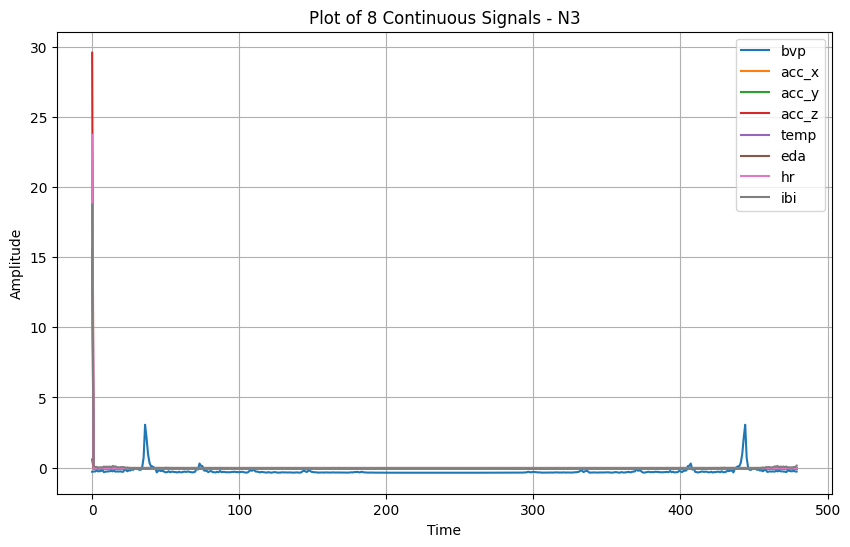

In [12]:
import random

# สมมติว่า activity_map และ y_train ถูกกำหนดไว้แล้ว
activity_map = {
    0: "W",  # N: Nap
    1: "R",
    2: "N1",
    3: "N2",  # R: Rest
    4: "N3",  # W: Wake

}

# Generate a random sample index
sample_index = random.randint(0, len(y_train) - 1)  # Random index within the dataset
print(f"Randomly selected sample index: {sample_index}")

# Extract signal for the sample
signal_array = X_train[sample_index]  # Get the signal for the selected sample
time = np.arange(signal_array.shape[0])  # Time axis

# Get activity label and its name
activity_label = int(y_train[sample_index])  # Activity label for the sample
activity_name = activity_map[activity_label]

# Define the signal names (order must match the columns in the data)
signals = ['bvp', 'acc_x', 'acc_y', 'acc_z', 'temp', 'eda', 'hr', 'ibi']

# Plot the signals
plt.figure(figsize=(10, 6))
for i in range(signal_array.shape[1]):
    plt.plot(time, signal_array[:, i], label=f'{signals[i]}')

# Add labels, title, legend, and grid
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f'Plot of 8 Continuous Signals - {activity_name}')
plt.legend()
plt.grid()
plt.show()


In [49]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def f1_weighted(y_true, y_pred):
    num_classes = K.int_shape(y_pred)[-1] 
    y_pred_labels = K.argmax(y_pred, axis=-1)

    f1_scores = []
    weights = []

    for i in range(num_classes):
        true_mask = K.cast(K.equal(y_true, i), 'float64')
        pred_mask = K.cast(K.equal(y_pred_labels, i), 'float64')

        tp = K.sum(true_mask * pred_mask)
        fp = K.sum(pred_mask) - tp
        fn = K.sum(true_mask) - tp

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        f1_scores.append(f1)

        class_weight = K.sum(true_mask)
        weights.append(class_weight)

    f1_scores = K.stack(f1_scores)
    weights = K.stack(weights)
    weights /= K.sum(weights) + K.epsilon()  # Normalize weights

    return K.sum(f1_scores * weights)  # Weighted average

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2


model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    Dropout(0.3),

    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(5, activation="softmax") 
])

model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.05),
    metrics=[f1_weighted] 
)

## TCN Model

In [85]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# def tcn_model(input_shape, num_classes):
#     inputs = Input(shape=input_shape)
#     x = Conv1D(64, 3, padding='same', activation='relu', dilation_rate=1)(inputs)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
#     x = Conv1D(64, 3, padding='same', activation='relu', dilation_rate=2)(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
#     x = Conv1D(64, 3, padding='same', activation='relu', dilation_rate=4)(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
#     x = GlobalAveragePooling1D()(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
#     return Model(inputs, outputs)

# model = tcn_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=5)
# optimizer = Adam(learning_rate=0.05) #reduced learning rate
# model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[f1_weighted])
# early_stopping = EarlyStopping(monitor='val_f1_weighted', mode='min', patience=10, restore_best_weights=True)
# model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=64, callbacks=[early_stopping])

Epoch 1/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - f1_weighted: 0.4544 - loss: 1.2434 - val_f1_weighted: 0.5019 - val_loss: 1.4139
Epoch 2/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - f1_weighted: 0.4639 - loss: 1.1965 - val_f1_weighted: 0.5056 - val_loss: 1.3468
Epoch 3/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - f1_weighted: 0.4671 - loss: 1.1776 - val_f1_weighted: 0.5189 - val_loss: 1.2300
Epoch 4/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - f1_weighted: 0.4629 - loss: 1.1769 - val_f1_weighted: 0.5144 - val_loss: 1.2405
Epoch 5/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - f1_weighted: 0.4715 - loss: 1.1638 - val_f1_weighted: 0.5195 - val_loss: 1.2072
Epoch 6/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - f1_weighted: 0.4766 - loss: 1.1505 - val_f1_weighted: 0.5186 - val_loss: 1.1862
Epoch 7/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - f1_weighted: 0.4803 - loss: 1.1379 - val_f1_weighted: 0.4873 - val_loss: 1.2801
Epoch 8/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step 

Normal Model Training

In [68]:
# checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

# history = model.fit(
#     X_train, y_train,
#     epochs=40,
#     validation_split=0.2,
#     verbose=2,
#     batch_size=64,
#     callbacks=[checkpoint]
# )

# model.load_weights("best_model.keras")

Epoch 1/40

Epoch 1: val_loss improved from inf to 1.28806, saving model to best_model.keras
835/835 - 22s - 27ms/step - f1_weighted: 0.3485 - loss: 1.3216 - val_f1_weighted: 0.3839 - val_loss: 1.2881
Epoch 2/40

Epoch 2: val_loss improved from 1.28806 to 1.28474, saving model to best_model.keras
835/835 - 19s - 22ms/step - f1_weighted: 0.3493 - loss: 1.2939 - val_f1_weighted: 0.3839 - val_loss: 1.2847
Epoch 3/40

Epoch 3: val_loss did not improve from 1.28474
835/835 - 19s - 22ms/step - f1_weighted: 0.3492 - loss: 1.2945 - val_f1_weighted: 0.3839 - val_loss: 1.2856
Epoch 4/40

Epoch 4: val_loss did not improve from 1.28474
835/835 - 18s - 22ms/step - f1_weighted: 0.3490 - loss: 1.2943 - val_f1_weighted: 0.3839 - val_loss: 1.2982
Epoch 5/40

Epoch 5: val_loss did not improve from 1.28474
835/835 - 18s - 22ms/step - f1_weighted: 0.3491 - loss: 1.2941 - val_f1_weighted: 0.3839 - val_loss: 1.2926
Epoch 6/40

Epoch 6: val_loss did not improve from 1.28474
835/835 - 19s - 22ms/step - f1_wei

KeyboardInterrupt: 

## Improve TCN Model

In [89]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

def residual_block(x, filters, dilation_rate):
    shortcut = x
    x = Conv1D(filters, 3, padding='same', activation='relu', dilation_rate=dilation_rate, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Conv1D(filters, 3, padding='same', activation='relu', dilation_rate=dilation_rate, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Add()([shortcut, x]) #residual connection
    return x

def improved_tcn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, padding='same', activation='relu', dilation_rate=1, kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = residual_block(x, 64, 2)
    x = residual_block(x, 64, 4)
    x = residual_block(x, 64, 8)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

model = improved_tcn_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=5)
optimizer = Adam(learning_rate=0.01) #much lower learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=[f1_weighted])

early_stopping = EarlyStopping(monitor='val_f1_weighted', mode='max', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_f1_weighted', factor=0.5, patience=5, min_lr=0.00001, mode='max', verbose=1)

model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=64, callbacks=[early_stopping, reduce_lr])

Epoch 1/200
835/835 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - f1_weighted: 0.4539 - loss: 1.3832 - val_f1_weighted: 0.5103 - val_loss: 1.2999 - learning_rate: 0.0100
Epoch 2/200
835/835 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - f1_weighted: 0.4629 - loss: 1.2396 - val_f1_weighted: 0.4414 - val_loss: 1.3547 - learning_rate: 0.0100
Epoch 3/200
835/835 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - f1_weighted: 0.4615 - loss: 1.2168 - val_f1_weighted: 0.5052 - val_loss: 1.2654 - learning_rate: 0.0100
Epoch 4/200
835/835 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - f1_weighted: 0.4675 - loss: 1.2043 - val_f1_weighted: 0.4976 - val_loss: 1.2612 - learning_rate: 0.0100
Epoch 5/200
835/835 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - f1_weighted: 0.4639 - loss: 1.2019 - val_f1_weighted: 0.4904 - val_loss: 1.5263 - learning_rate: 0.0100
Epoch 6/200
833/835 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_weighted: 0.4679 - loss: 1.1906
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
835/835 ━━━━━━━━━━━━━━━━━━━━ 

In [90]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

# Define the directory containing the test files
test_dir = '/kaggle/input/spai-signal-sleep-staging-classification/test_segment/test_segment'

# List all the test CSV files
test_files = []
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith('.csv'):
            test_files.append(os.path.join(root, file))

# Sort files if needed
test_files.sort()

# Use preprocess_time_series function to load test data
X_test = preprocess_time_series_with_fft(test_files, is_training=False, window_size=480)

# Use StandardScaler to scale the test data
scaler = StandardScaler()
X_test_shape = X_test.shape
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test_shape)

# Predict using the model
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Define mapping for Sleep_Stage
activity_map = {0: "W", 1: "R", 2: "N1", 3: "N2", 4:"N3"}  # Mapping Sleep_Stage
prediction_mapped = [activity_map[x] for x in predicted_classes]

# Create the submission dataframe
modified_test_files = [os.path.basename(file).replace('.csv', '') for file in test_files]

# Generate the submission file in the same format as before (with ID and predicted labels)
submission = pd.DataFrame({
    'id': modified_test_files,
    'labels': prediction_mapped
})

# Save the submission dataframe to CSV
submission.to_csv('sub_residual.csv', index=False)

print("Submission file has been created!")

Processing Files: 100%|██████████| 7832/7832 [00:21<00:00, 362.08it/s]


245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Submission file has been created!


In [91]:
re = pd.read_csv("/kaggle/working/sub_residual.csv")

In [92]:
re['labels'].value_counts()

labels
N2    5841
W     1991
Name: count, dtype: int64

In [26]:
sub = pd.read_csv("/kaggle/input/io-t-sleep-stage-classification-version-2/sample_submission.csv")
sub

,id,labels
0,test001_00000,W
1,test001_00001,W
2,test001_00002,W
3,test001_00003,NaN
4,test001_00004,NaN
...,...,...
7005,test010_00696,NaN
7006,test010_00697,NaN
7007,test010_00698,NaN
7008,test010_00699,NaN
